## Using custom scheduler in Transformers.Trainer

This notebooks demonstrates how to use custom Learning Rate Scheduler in `Transforers.Trainer`

Specifically, we show how to define the learning rate in the end of a training run when using default linear scheduler with warmup

In [25]:
!pip install transformers >/dev/null

In [28]:
!pip install datasets > /dev/null

In [1]:
import transformers
from transformers import Trainer, TrainingArguments
import datasets as hfd

import torch
import torch.nn as nn

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set();

## Transformers.Trainer

### Create random dataset

In [2]:
n = 8
input_features = np.random.rand(n, 100).tolist()
labels = np.random.rand(n)

In [3]:
ds = hfd.Dataset.from_dict({'input_features': input_features, 'labels': labels})
ds

Dataset({
    features: ['input_features', 'labels'],
    num_rows: 8
})

### Functions

In [4]:
class SimpleModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.lstm = nn.LSTM(input_size=1, hidden_size=1, num_layers=1)

  def forward(self, x):
    bs = x.size(1)
    ht, (hn, cn) = self.lstm(x)
    return hn.reshape(bs)  # batch_size

class SimpleModelWrapper(nn.Module):
  def __init__(self, model: SimpleModel):
    super().__init__()
    self.model = model
    self.loss_fn = nn.CrossEntropyLoss()

  def forward(self, input_features, labels: torch.Tensor = None):
    logits = self.model(input_features)

    if labels is not None:
      loss = self.loss_fn(logits, labels)
    return {'loss': loss, 'logits': logits}

In [5]:
class TrainerCustomLinearScheduler(Trainer):
  @staticmethod
  def scheduler_n_steps_for_fixed_lr_in_end(lr_max, lr_end, num_train_steps, num_warmup_steps) -> int:
    assert lr_end < lr_max
    return num_warmup_steps + (num_train_steps - num_warmup_steps) * lr_max / (lr_max - lr_end)

  def create_scheduler(self, num_training_steps: int, optimizer: torch.optim.Optimizer = None):
    use_custom_scheduler = False
    try:
      # if learning_rate_end was passed as an argument
      learning_rate_end = self.args.learning_rate_end
      use_custom_scheduler = True
      print('TrainerCustomLinearScheduler.create_scheduler(). '
            'initializing custom linear scheduler using learning_rate_end argument')
    except:
      print('TrainerCustomLinearScheduler.create_scheduler(). '
            'learning_rate_end was not set. fallback to a default behavior')

    if use_custom_scheduler is True:
      scheduler_num_steps = self.scheduler_n_steps_for_fixed_lr_in_end(
          lr_max=self.args.learning_rate, 
          lr_end=learning_rate_end, 
          num_train_steps=num_training_steps, 
          num_warmup_steps=self.args.warmup_steps
      )

      self.lr_scheduler = transformers.get_scheduler(
          'linear', optimizer=optimizer, 
          num_warmup_steps=self.args.warmup_steps, 
          num_training_steps=scheduler_num_steps
      )
      return self.lr_scheduler
    else:
      return super().create_scheduler(num_training_steps, optimizer)

In [6]:
def collate_fn(batch):
  input_features = [x['input_features'] for x in batch]
  input_features = torch.FloatTensor(input_features).t()
  seq, bs = input_features.size()
  input_features = input_features.reshape(seq, bs, 1)  # seq, bs, n_features
  
  labels = [x['labels'] for x in batch]
  res = {'input_features': input_features, 'labels': torch.FloatTensor(labels)}
  
  return res

In [7]:
def get_steps_lrs_from_trainer_history(trainer):
  lrs = {x['step']: x['learning_rate'] for x in trainer.state.log_history[:-1]}
  lrs = sorted(lrs.items(), key=lambda x: x[0])
  steps = [x[0] for x in lrs]
  lrs = [x[1] for x in lrs]
  return {'steps': steps, 'lrs': lrs}

In [8]:
model = SimpleModel()
model_wrapper = SimpleModelWrapper(model=model)

### With warmup

In [9]:
learning_rate = 1e-2
learning_rate_end = 5e-3

training_args = TrainingArguments(
    output_dir='tmp', per_device_train_batch_size=8, max_steps=100, 
    logging_strategy='steps', logging_steps=1, 
    logging_first_step=True,  # does not matter becuase logging_steps=1
    warmup_steps=20,
    learning_rate=learning_rate
)
training_args.learning_rate_end = learning_rate_end

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [10]:
custom_trainer = TrainerCustomLinearScheduler(model=model_wrapper, args=training_args, train_dataset=ds, data_collator=collate_fn)
custom_trainer.remove_callback(transformers.utils.notebook.NotebookProgressCallback)  # for clear output. we are logging learning rate every step
custom_trainer.train();

max_steps is given, it will override any value given in num_train_epochs
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 8
  Num Epochs = 100
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 100
  Number of trainable parameters = 16


TrainerCustomLinearScheduler.create_scheduler(). initializing custom linear scheduler using learning_rate_end argument




Training completed. Do not forget to share your model on huggingface.co/models =)




In [11]:
trainer = Trainer(model=model_wrapper, args=training_args, train_dataset=ds, data_collator=collate_fn)
trainer.remove_callback(transformers.utils.notebook.NotebookProgressCallback)  # for clear output. we are logging learning rate every step
trainer.train();

max_steps is given, it will override any value given in num_train_epochs
***** Running training *****
  Num examples = 8
  Num Epochs = 100
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 100
  Number of trainable parameters = 16


Training completed. Do not forget to share your model on huggingface.co/models =)




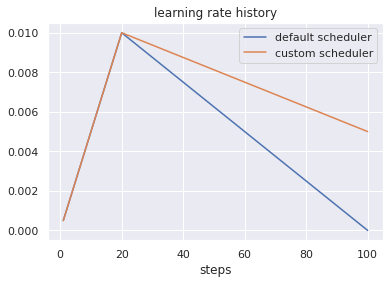

In [12]:
history = get_steps_lrs_from_trainer_history(trainer)
history_custom = get_steps_lrs_from_trainer_history(custom_trainer)
plt.plot(history['steps'], history['lrs'], label='default scheduler');
plt.plot(history_custom['steps'], history_custom['lrs'], label='custom scheduler');
plt.legend();
plt.title('learning rate history');
plt.xlabel('steps');

### No warmup

In [13]:
learning_rate = 1e-2
learning_rate_end = 5e-3

training_args = TrainingArguments(
    output_dir='tmp', per_device_train_batch_size=8, max_steps=100, 
    logging_strategy='steps', logging_steps=1, 
    logging_first_step=True,  # does not matter becuase logging_steps=1
    warmup_steps=0,
    learning_rate=learning_rate
)
training_args.learning_rate_end = learning_rate_end

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [14]:
custom_trainer = TrainerCustomLinearScheduler(model=model_wrapper, args=training_args, train_dataset=ds, data_collator=collate_fn)
custom_trainer.remove_callback(transformers.utils.notebook.NotebookProgressCallback)  # for clear output. we are logging learning rate every step
custom_trainer.train();

max_steps is given, it will override any value given in num_train_epochs
***** Running training *****
  Num examples = 8
  Num Epochs = 100
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 100
  Number of trainable parameters = 16


TrainerCustomLinearScheduler.create_scheduler(). initializing custom linear scheduler using learning_rate_end argument




Training completed. Do not forget to share your model on huggingface.co/models =)




In [15]:
trainer = Trainer(model=model_wrapper, args=training_args, train_dataset=ds, data_collator=collate_fn)
trainer.remove_callback(transformers.utils.notebook.NotebookProgressCallback)  # for clear output. we are logging learning rate every step
trainer.train();

max_steps is given, it will override any value given in num_train_epochs
***** Running training *****
  Num examples = 8
  Num Epochs = 100
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 100
  Number of trainable parameters = 16


Training completed. Do not forget to share your model on huggingface.co/models =)




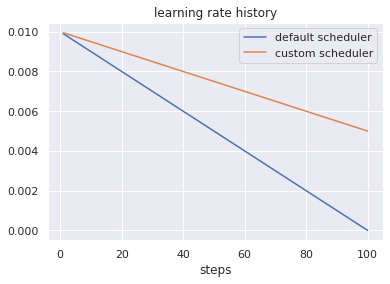

In [16]:
history = get_steps_lrs_from_trainer_history(trainer)
history_custom = get_steps_lrs_from_trainer_history(custom_trainer)
plt.plot(history['steps'], history['lrs'], label='default scheduler');
plt.plot(history_custom['steps'], history_custom['lrs'], label='custom scheduler');
plt.legend();
plt.title('learning rate history');
plt.xlabel('steps');

## Torch

In [17]:
def scheduler_n_steps_for_fixed_lr_in_end(lr_max, lr_end, num_train_steps, num_warmup_steps) -> int:
  return num_warmup_steps + (num_train_steps - num_warmup_steps) * lr_max / (lr_max - lr_end)

### With warmup

num_training_steps_scheduler: 1900.0


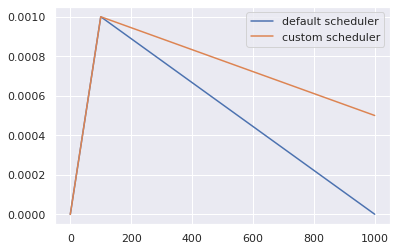

In [20]:
start_lr = 1e-3
end_lr = 5e-4
num_train_steps = 1000
num_warmup_steps = 100

optim1 = torch.optim.AdamW(model.parameters(), lr=start_lr)
optim2 = torch.optim.AdamW(model.parameters(), lr=start_lr)

num_training_steps_scheduler = scheduler_n_steps_for_fixed_lr_in_end(
    lr_max=start_lr, lr_end=end_lr, num_train_steps=num_train_steps, num_warmup_steps=num_warmup_steps
)
print(f'num_training_steps_scheduler: {num_training_steps_scheduler}')
s1 = transformers.get_scheduler('linear', optimizer=optim1, num_warmup_steps=num_warmup_steps, num_training_steps=num_train_steps)
s2 = transformers.get_scheduler('linear', optimizer=optim2, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps_scheduler)

lrs1 = []
lrs2 = []
for step in range(1000):
  lrs1.append(optim1.param_groups[0]['lr'])
  lrs2.append(optim2.param_groups[0]['lr'])
  s1.step()
  s2.step()

plt.plot(lrs1, label='default scheduler');
plt.plot(lrs2, label='custom scheduler');
plt.legend();

### No warmup

num_training_steps_scheduler: 2000.0


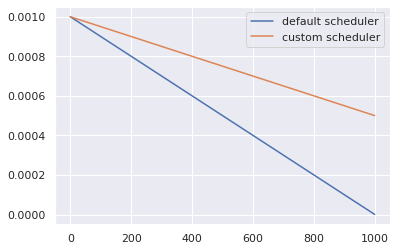

In [21]:
start_lr = 1e-3
end_lr = 5e-4
num_train_steps = 1000
num_warmup_steps = 0

optim1 = torch.optim.AdamW(model.parameters(), lr=start_lr)
optim2 = torch.optim.AdamW(model.parameters(), lr=start_lr)

num_training_steps_scheduler = scheduler_n_steps_for_fixed_lr_in_end(
    lr_max=start_lr, lr_end=end_lr, num_train_steps=num_train_steps, num_warmup_steps=num_warmup_steps
)
print(f'num_training_steps_scheduler: {num_training_steps_scheduler}')
s1 = transformers.get_scheduler('linear', optimizer=optim1, num_warmup_steps=num_warmup_steps, num_training_steps=num_train_steps)
s2 = transformers.get_scheduler('linear', optimizer=optim2, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps_scheduler)

lrs1 = []
lrs2 = []
for step in range(1000):
  lrs1.append(optim1.param_groups[0]['lr'])
  lrs2.append(optim2.param_groups[0]['lr'])
  s1.step()
  s2.step()

plt.plot(lrs1, label='default scheduler');
plt.plot(lrs2, label='custom scheduler');
plt.legend();